### This example shows how to optimise kernel parameters using the log marginal likelihood - a measure of how well the data is explained by the model. This script uses batch and sub-batch sampling, but not dynamic bounds reduction. It also shows in some more detail how to include Gaussian noise into the model. 

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('..')
import BOPackage

Text(0, 0.5, 'Y')

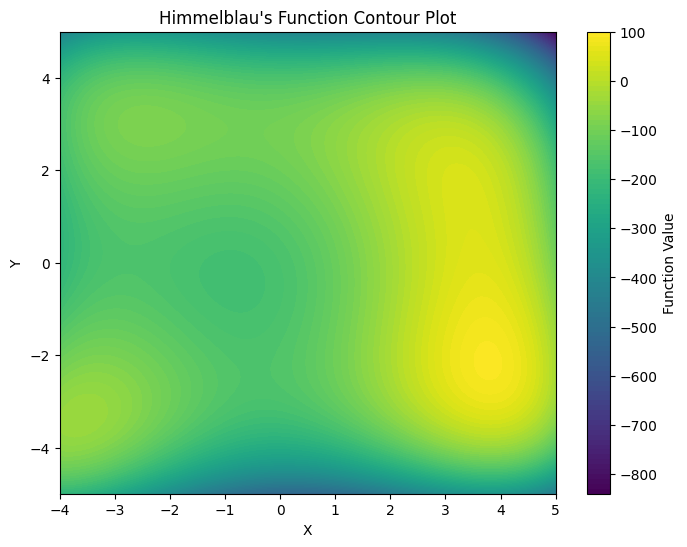

In [128]:
def ObjectiveFunction(X: np.ndarray) -> np.ndarray:
    """
    Himmelblau's function, a well-known benchmark function for optimization.
    
    Takes an (n, 2) matrix X where each row represents (x, y) coordinates.
    Returns an (n, 1) column vector of function values.
    
    f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
    
    """
    x = X[:, 0].astype(float)
    y = X[:, 1].astype(float)
    return - np.expand_dims((x**2 + y - 11)**2 + (x + y**2 - 7)**2 - 20*x + 10*y, axis=1)

X1 = np.linspace(-4, 5, 100)
X2 = np.linspace(-5, 5, 100)
X1_mesh, X2_mesh = np.meshgrid(X1, X2)
candidate_x = np.vstack([X1_mesh.ravel(), X2_mesh.ravel()]).T

Z = ObjectiveFunction(np.c_[X1_mesh.ravel(), X2_mesh.ravel()]).reshape(X1_mesh.shape)

plt.figure(figsize=(8, 6))
plt.contourf(X1_mesh, X2_mesh, Z, levels=100, cmap='viridis')
plt.colorbar(label='Function Value')
plt.title("Himmelblau's Function Contour Plot")
plt.xlabel("X")
plt.ylabel("Y")

In [129]:
def PriorMeanFunction(X):
    return - np.ones(len(X)).reshape(len(X), 1)

In [130]:
"""
Configure the optimiser Starting with a lengthscale that is clearly too large for our objective function.
"""
PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_CPU
length_scale = np.array([[0.5], [1.5]])             # Way too large!
noise = 1e-3                    # Quite sizable noise, note throughout the images that the variance at sampled locations doesnt drop to 0.

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 10                  # Maximum kappa value used in the acquisition function for the batch
min_kappa = 0.1                 # Minimum kappa value used in the acquisition function for the batch

bounds = np.array([[-4, 5], [-5, 5]])
acquisition_samples = 10000        # Number of random points in the domain to calculate the acqusition function value at. The point with the highest acquisition function value will be added to the raw_X for the batch

random_seed = None                # random seed for reproducability if wanted. 

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed,
                  noise=noise)

[[-4 -5]
 [ 5  5]
 [ 1 -1]] [[-226.]
 [-840.]
 [-116.]]


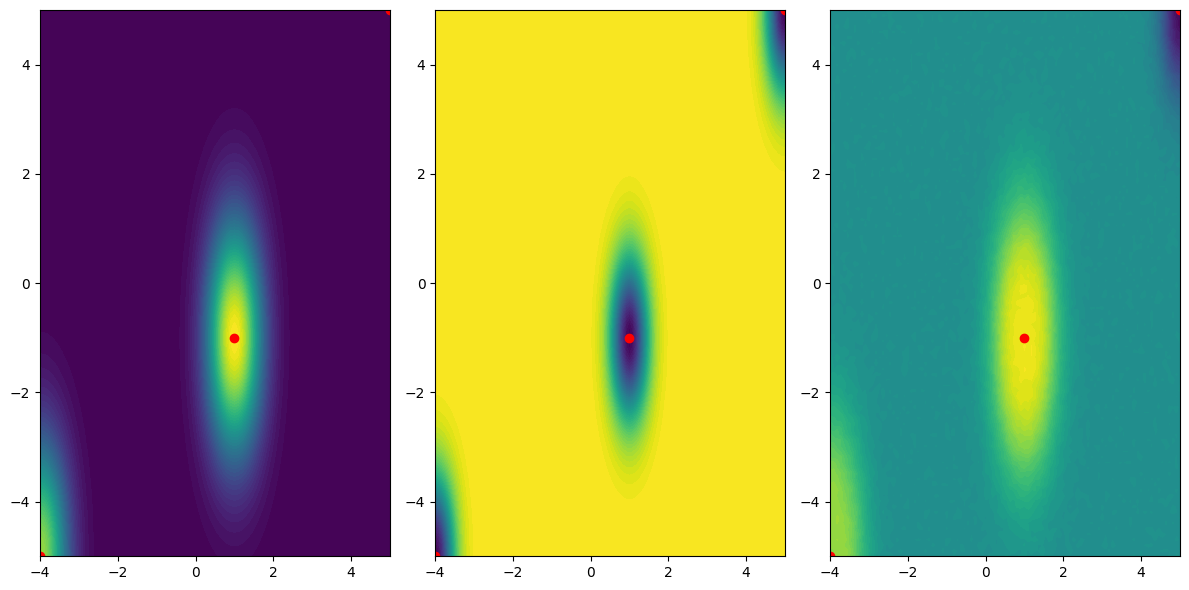

In [131]:
"""
Get first random batch and update the optimiser.
"""

raw_X = np.array([[-4, -5], [5, 5], [1, -1]])
# raw_X = bo.GetRandomXBatch(batch_size=4)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

print(bo.X_data, bo.y_data)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [9.65304847 2.62707668]
Function value at optimum: 378219.1156565358
Converged: True
Number of iterations: 28
Number of function evaluations: 117


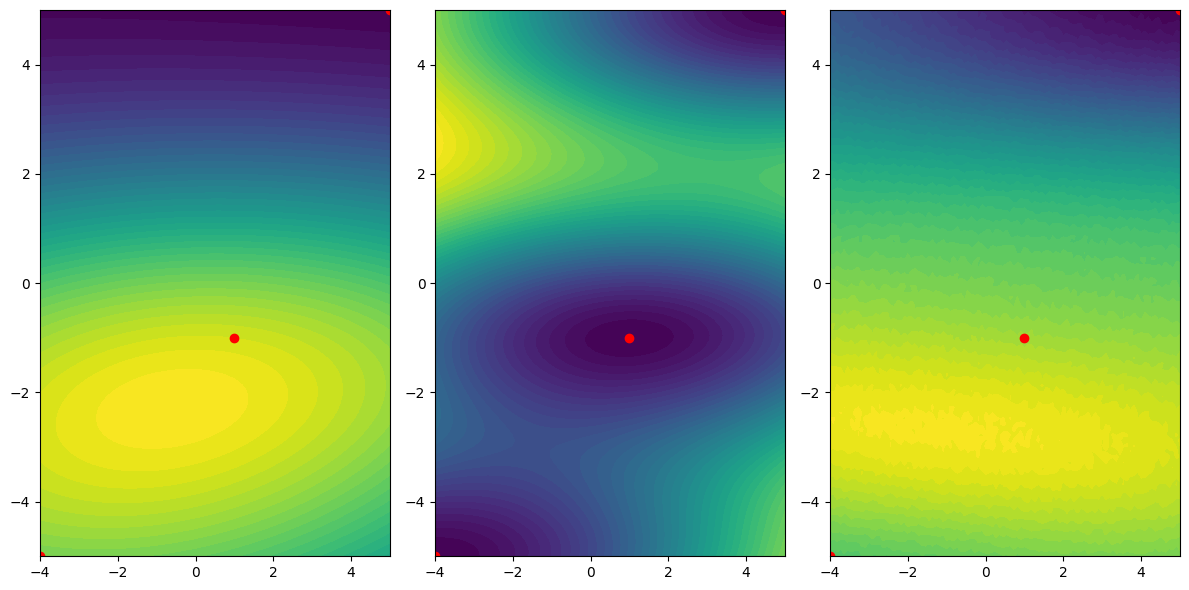

In [132]:
new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [4.27315383e+04 4.90474479e-01]
Function value at optimum: 399892.2103071395
Converged: True
Number of iterations: 31
Number of function evaluations: 111


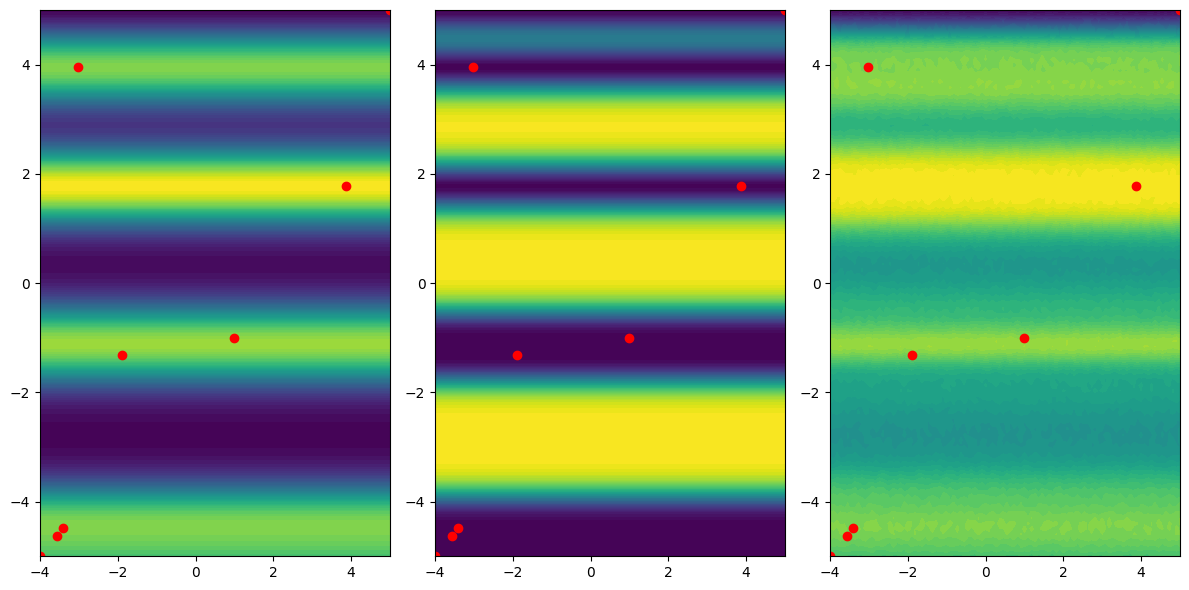

In [133]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [3.00059726 0.39390083]
Function value at optimum: 427848.45448137063
Converged: True
Number of iterations: 12
Number of function evaluations: 45


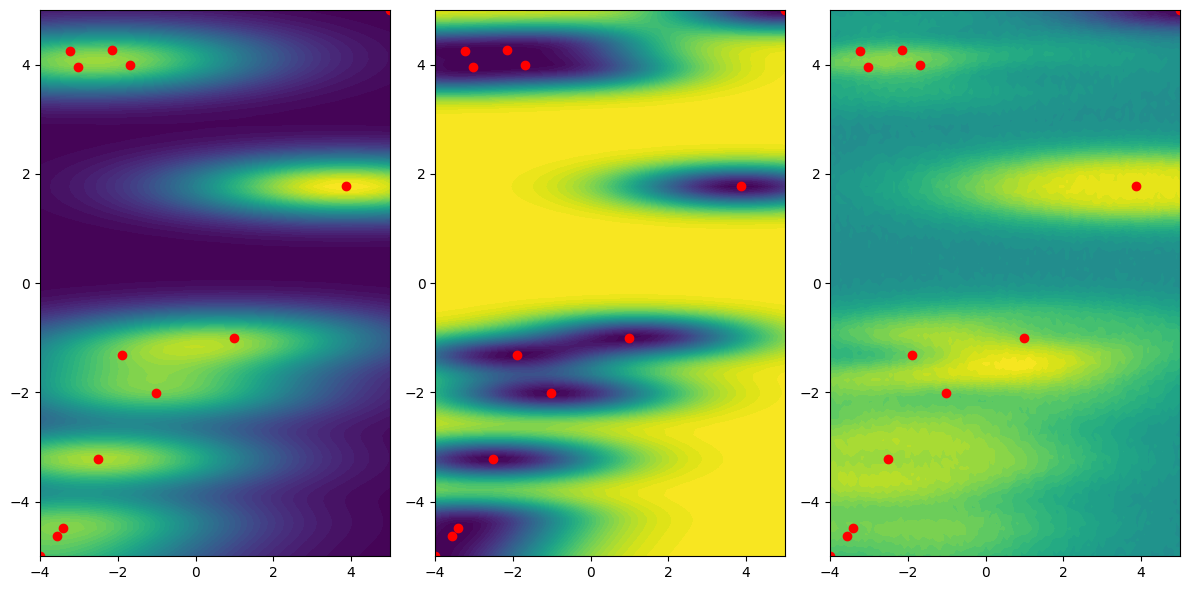

In [134]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [0.49925986 5.91843723]
Function value at optimum: 450267.98822442716
Converged: True
Number of iterations: 19
Number of function evaluations: 81


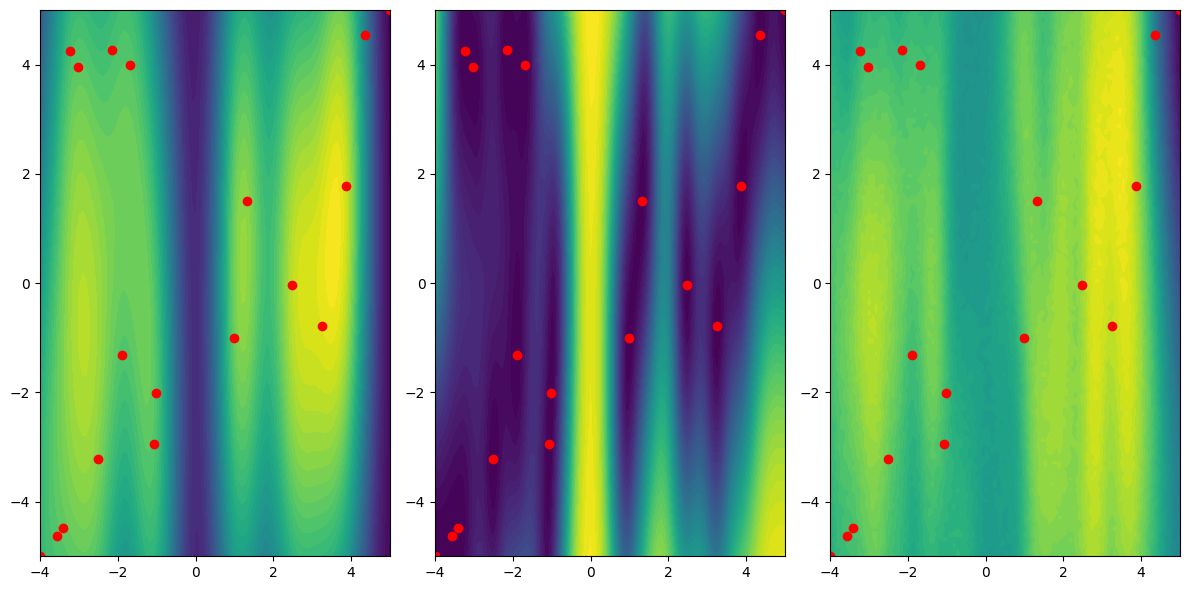

In [135]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [0.52570874 3.54008645]
Function value at optimum: 457771.98171912314
Converged: True
Number of iterations: 15
Number of function evaluations: 51


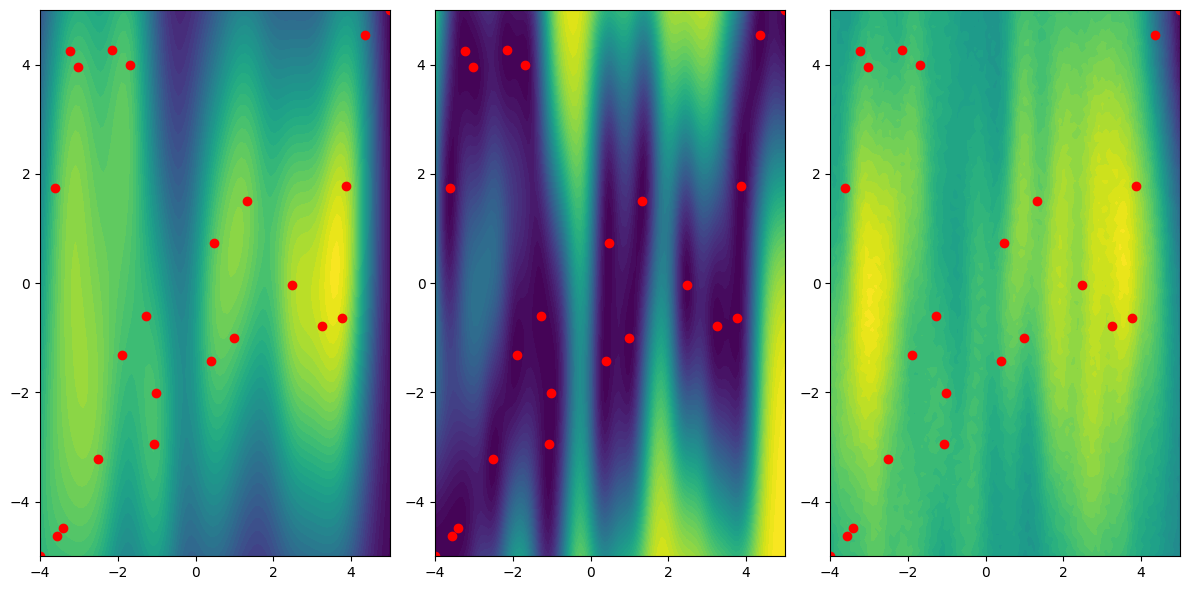

In [136]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [0.5458618  2.35465492]
Function value at optimum: 489014.5210467238
Converged: True
Number of iterations: 15
Number of function evaluations: 51


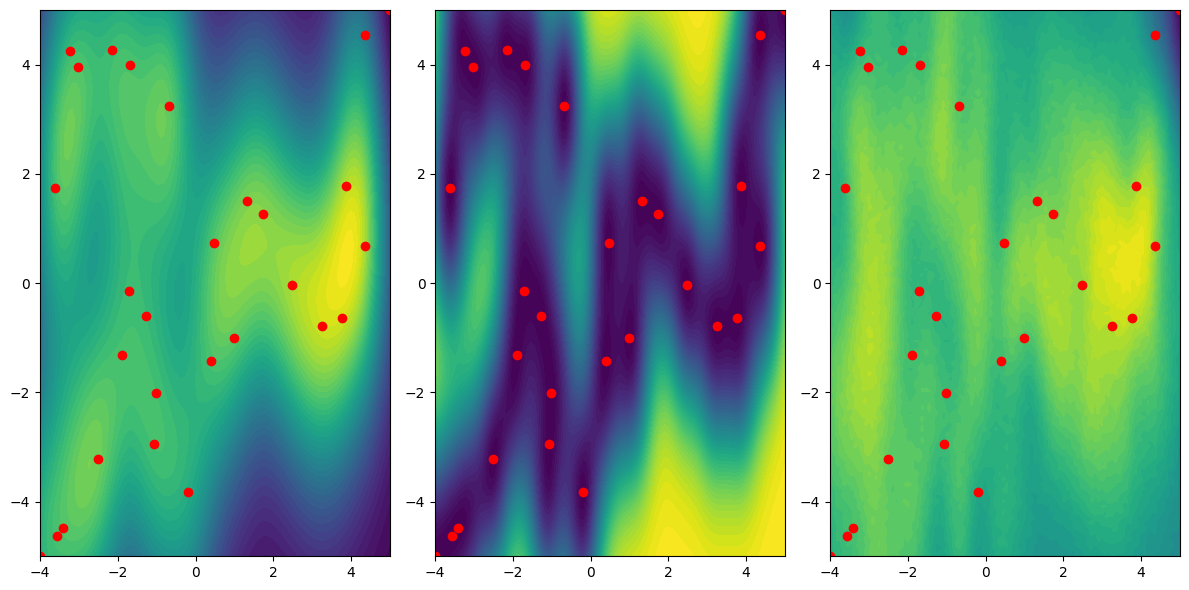

In [137]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [0.57415267 1.97267111]
Function value at optimum: 557293.1104224208
Converged: True
Number of iterations: 23
Number of function evaluations: 99


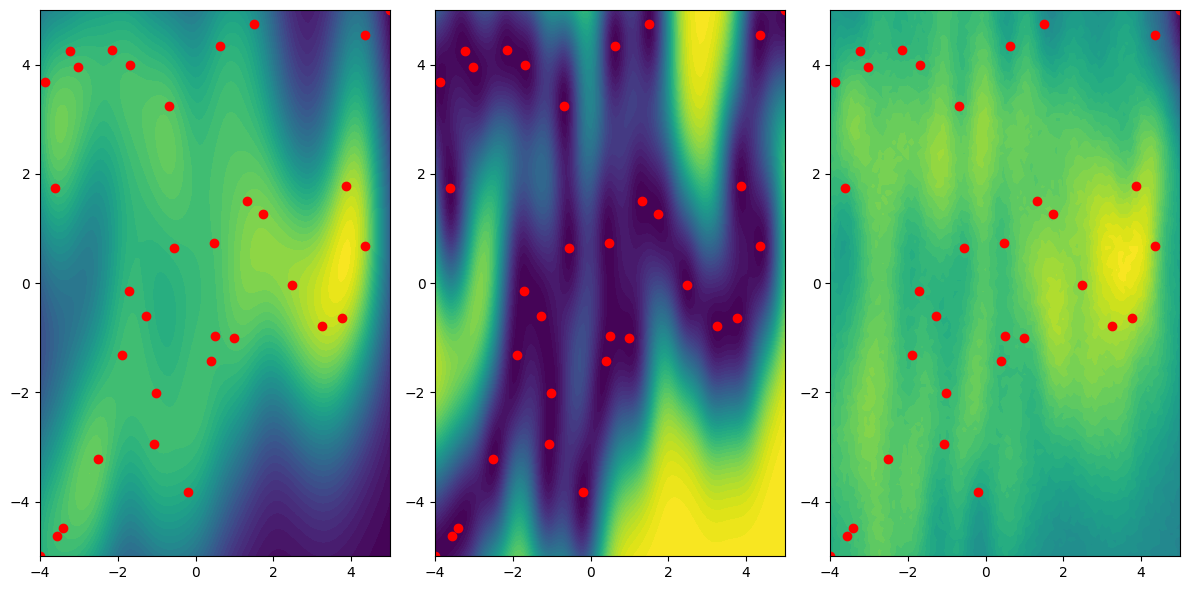

In [138]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [2.13802231 0.39697523]
Function value at optimum: 567813.795090863
Converged: True
Number of iterations: 18
Number of function evaluations: 63


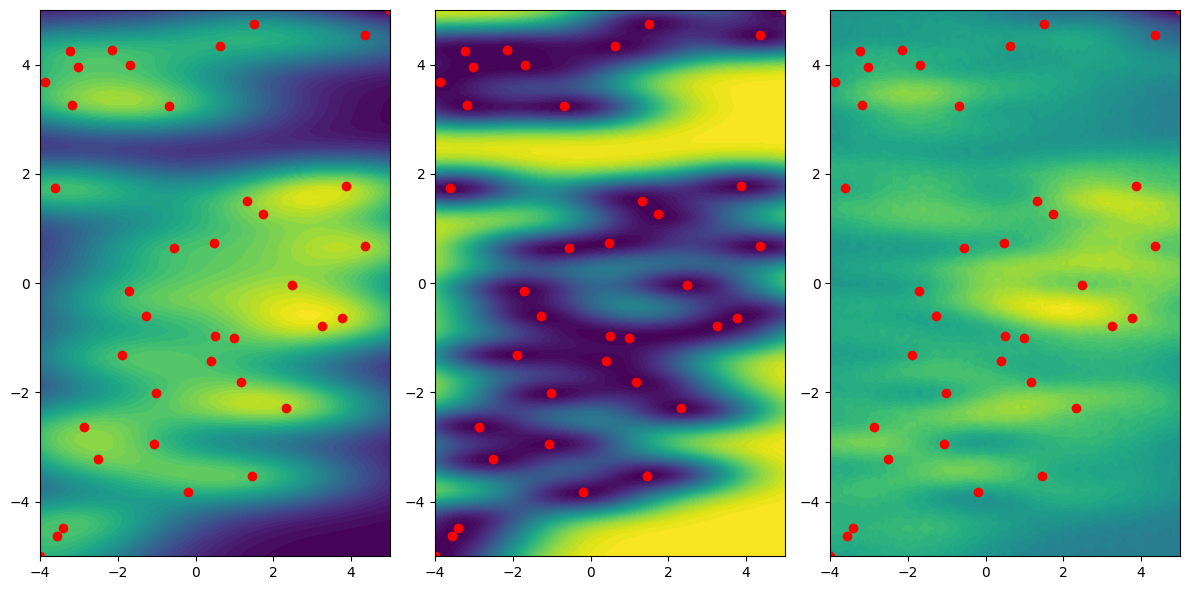

In [139]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [2.09703594 0.3863493 ]
Function value at optimum: 632094.0220043368
Converged: True
Number of iterations: 15
Number of function evaluations: 48


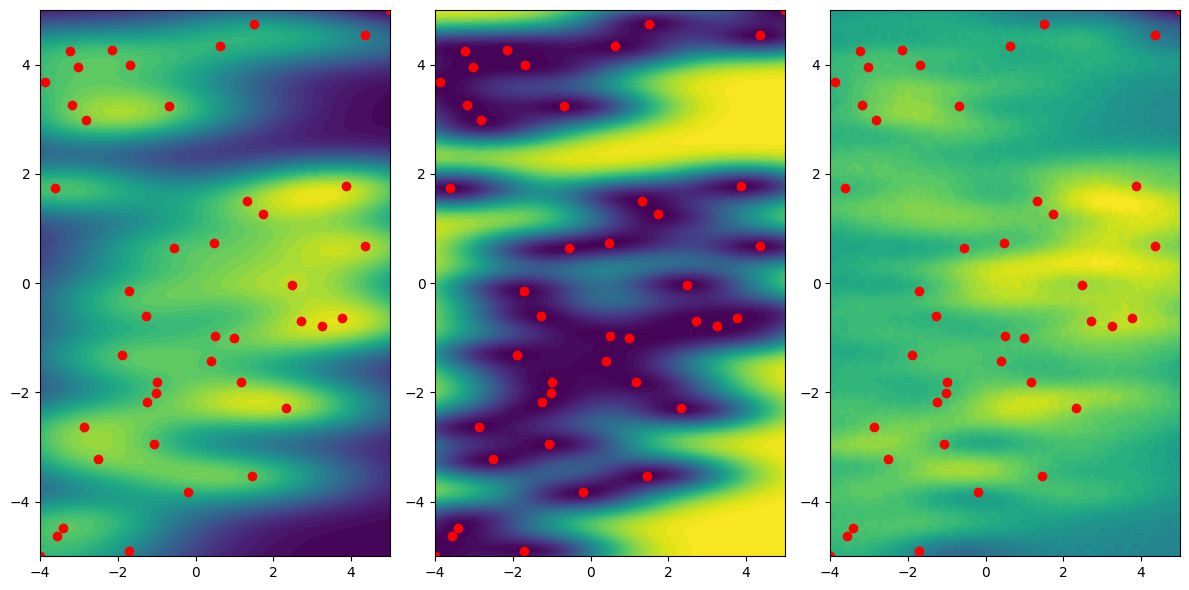

In [140]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [2.01101265 0.41358423]
Function value at optimum: 646992.3864626632
Converged: True
Number of iterations: 20
Number of function evaluations: 75


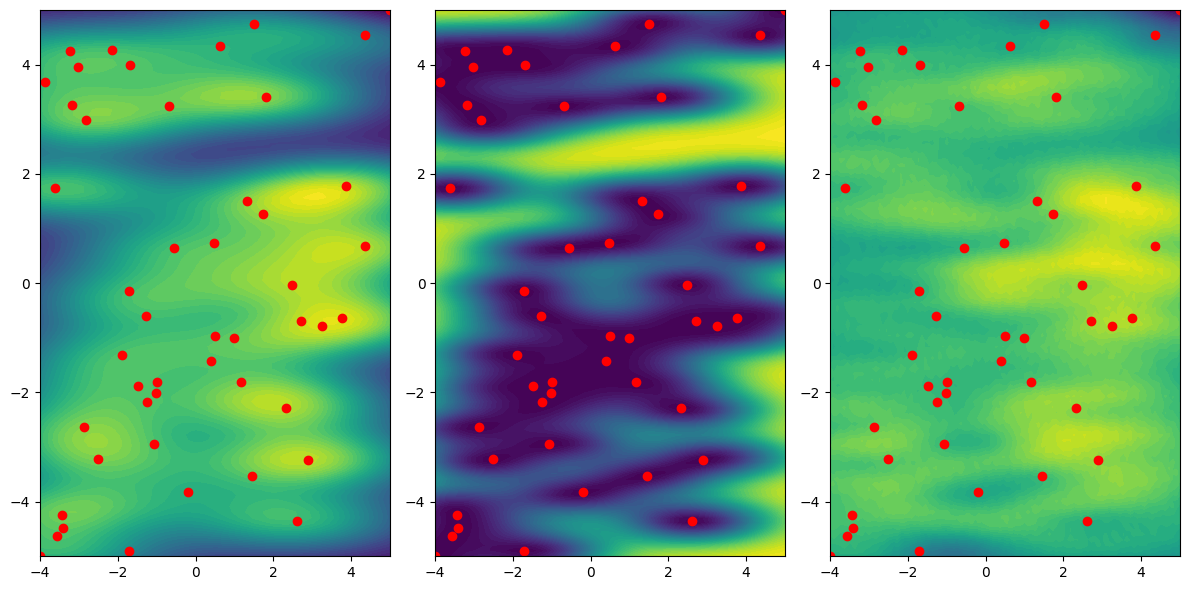

In [141]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [2.0120931  0.39033441]
Function value at optimum: 654579.4928487863
Converged: True
Number of iterations: 18
Number of function evaluations: 75


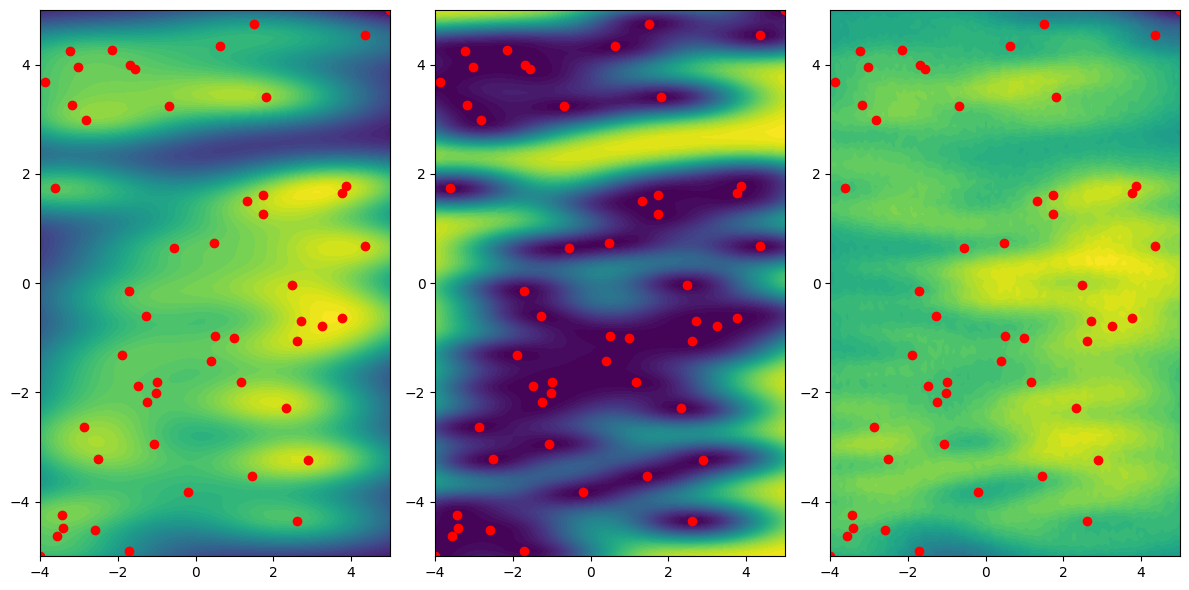

In [142]:
raw_X = bo.GetRandomXBatch(batch_size=5)
raw_Y = ObjectiveFunction(raw_X)

bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

Optimal parameters: [0.83589508 0.42979396]
Function value at optimum: 1906681.5490115937
Converged: True
Number of iterations: 16
Number of function evaluations: 51


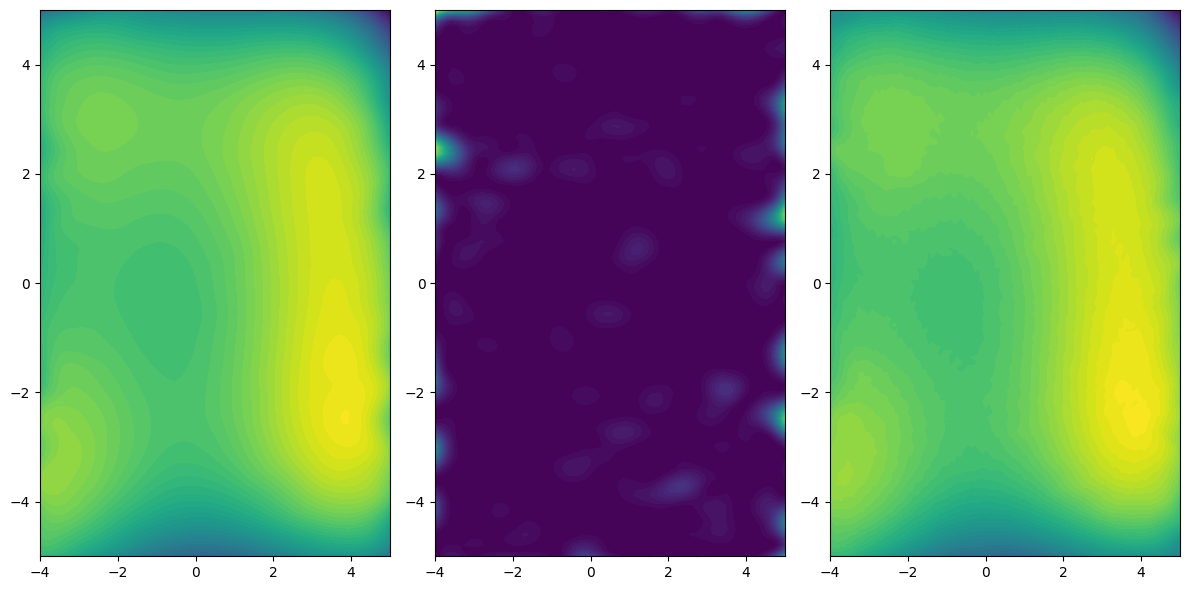

In [143]:
for i in range(95):
    raw_X = bo.GetRandomXBatch(batch_size=5)
    raw_Y = ObjectiveFunction(raw_X)

    bo.UpdateData(raw_X, raw_Y)

new_length_scales = BOPackage.OptimiseLML(Kernel, bo.X_data, bo.y_data, 1e-4, np.array([5, 5]), lambda_penalty=0)
bo.length_scale = new_length_scales.reshape(-1, 1)

mean, variance = bo.PredictMeanVariance(candidate_x)
acq_function = bo.AcquisitionFunction(mean, variance, kappa=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axs[0].contourf(X1, X2, mean.reshape(len(X1), len(X2)), levels=50)
# axs[0].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[1].contourf(X1, X2, variance.reshape(len(X1), len(X2)), levels=50)
# axs[1].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

axs[2].contourf(X1, X2, acq_function.reshape(len(X1), len(X2)), levels=50)
# axs[2].scatter(bo.X_data[:, 0], bo.X_data[:, 1], color='red')

plt.tight_layout()

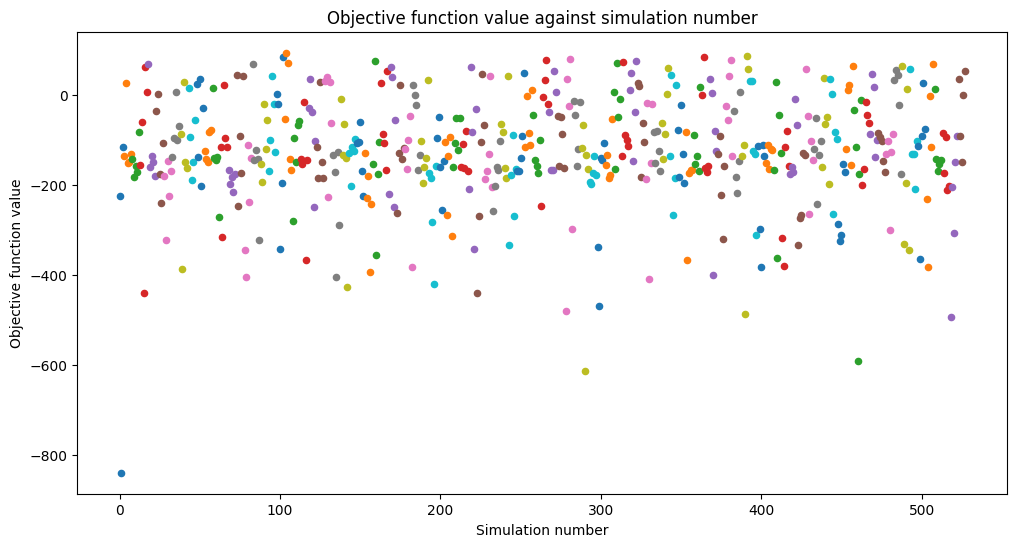

93.06821642575983

In [144]:
BOPackage.PlotData(bo)
np.max(bo.y_data)